In [0]:
!pip install pyspark

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql import SparkSession

In [0]:
data = spark.read.csv("/Volumes/workspace/default/projects/bigdata_2018_2022.csv", header = True, inferSchema=True)

In [0]:
data.show(5)

+----------+----+--------------+-------------------+----------+
|      date|hour|origin_station|destination_station|trip_count|
+----------+----+--------------+-------------------+----------+
|2018-01-01|   0|          12th|               12th|         3|
|2018-01-01|   0|          12th|               16th|         1|
|2018-01-01|   0|          12th|               bayf|         1|
|2018-01-01|   0|          12th|               cast|         3|
|2018-01-01|   0|          12th|               civc|         2|
+----------+----+--------------+-------------------+----------+
only showing top 5 rows


In [0]:
data = data.dropna()

In [0]:
data.dropDuplicates().count()

30176143

In [0]:
# Cleaning data
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, to_date
from pyspark.sql.types import DoubleType, IntegerType

numeric_columns = ['hour', 'trip_count']
for c in numeric_columns:
    data = data.withColumn(c, col(c).cast(DoubleType()))

In [0]:
# Cleaning data
categorical_columns = ['origin_station', 'destination_station']
for c in categorical_columns:
    data = data.withColumn(c, lower(trim(col(c))))

In [0]:
# Cleaning data
data = data.withColumn("date", to_date(col("Date"), "yyyy-MM-dd"))

In [0]:
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- hour: double (nullable = true)
 |-- origin_station: string (nullable = true)
 |-- destination_station: string (nullable = true)
 |-- trip_count: double (nullable = true)



In [0]:
from pyspark.sql.functions import dayofweek, when, col

# dayofweek in Spark: 1=Sunday, 2=Monday, ..., 7=Saturday
data = data.withColumn(
    "day_type",
    when(dayofweek(col("Date")).isin(1,7), "weekend").otherwise("weekday")  
)

data.select("date", "day_type").show(5)

+----------+--------+
|      date|day_type|
+----------+--------+
|2018-01-01| weekday|
|2018-01-01| weekday|
|2018-01-01| weekday|
|2018-01-01| weekday|
|2018-01-01| weekday|
+----------+--------+
only showing top 5 rows


In [0]:
from pyspark.sql.functions import sum as _sum

daily_counts = (
    data.groupBy("date", "day_type")
      .agg(_sum("trip_count").alias("trip_count"))
      .orderBy("date")
)

daily_counts.show()

+----------+--------+----------+
|      date|day_type|trip_count|
+----------+--------+----------+
|2018-01-01| weekday|  110254.0|
|2018-01-02| weekday|  332343.0|
|2018-01-03| weekday|  361718.0|
|2018-01-04| weekday|  369714.0|
|2018-01-05| weekday|  347483.0|
|2018-01-06| weekend|  145024.0|
|2018-01-07| weekend|   99029.0|
|2018-01-08| weekday|  374663.0|
|2018-01-09| weekday|  393468.0|
|2018-01-10| weekday|  411169.0|
|2018-01-11| weekday|  409727.0|
|2018-01-12| weekday|  384441.0|
|2018-01-13| weekend|  153573.0|
|2018-01-14| weekend|  110078.0|
|2018-01-15| weekday|  181604.0|
|2018-01-16| weekday|  412035.0|
|2018-01-17| weekday|  414895.0|
|2018-01-18| weekday|  411505.0|
|2018-01-19| weekday|  392550.0|
|2018-01-20| weekend|  231275.0|
+----------+--------+----------+
only showing top 20 rows


In [0]:
from pyspark.sql.functions import col, date_format, avg

monthly_counts = (
    daily_counts.withColumn("month", date_format(col("date"), "yyyy-MM-01"))
                .groupBy("month", "day_type")
                .agg(avg("trip_count").alias("trip_count"))
                .orderBy("month")
)

monthly_counts.show()

+----------+--------+------------------+
|     month|day_type|        trip_count|
+----------+--------+------------------+
|2018-01-01| weekday|          376024.0|
|2018-01-01| weekend|        142176.625|
|2018-02-01| weekday|         404399.95|
|2018-02-01| weekend|          146773.5|
|2018-03-01| weekday| 411693.9090909091|
|2018-03-01| weekend|          145261.0|
|2018-04-01| weekday| 415635.8095238095|
|2018-04-01| weekend|146791.11111111112|
|2018-05-01| weekday|406370.04347826086|
|2018-05-01| weekend|         156137.25|
|2018-06-01| weekend|172109.55555555556|
|2018-06-01| weekday|423025.85714285716|
|2018-07-01| weekend|151874.11111111112|
|2018-07-01| weekday|389190.54545454547|
|2019-01-01| weekday| 376023.6956521739|
|2019-01-01| weekend|        124530.875|
|2019-02-01| weekend|        130457.375|
|2019-02-01| weekday|         398127.85|
|2019-03-01| weekday|412491.85714285716|
|2019-03-01| weekend|          132941.8|
+----------+--------+------------------+
only showing top

In [0]:
from pyspark.sql.functions import to_date, date_format, col


daily_counts_spark = daily_counts

# monthly_counts: แปลง string เดือนให้เป็น date (แทน pd.to_datetime)
monthly_counts_spark = monthly_counts.withColumn(
    "month", to_date(col("month"), "yyyy-MM-dd")
)

monthly_counts_spark.show()

+----------+--------+------------------+
|     month|day_type|        trip_count|
+----------+--------+------------------+
|2018-01-01| weekday|          376024.0|
|2018-01-01| weekend|        142176.625|
|2018-02-01| weekday|         404399.95|
|2018-02-01| weekend|          146773.5|
|2018-03-01| weekday| 411693.9090909091|
|2018-03-01| weekend|          145261.0|
|2018-04-01| weekday| 415635.8095238095|
|2018-04-01| weekend|146791.11111111112|
|2018-05-01| weekday|406370.04347826086|
|2018-05-01| weekend|         156137.25|
|2018-06-01| weekend|172109.55555555556|
|2018-06-01| weekday|423025.85714285716|
|2018-07-01| weekend|151874.11111111112|
|2018-07-01| weekday|389190.54545454547|
|2019-01-01| weekday| 376023.6956521739|
|2019-01-01| weekend|        124530.875|
|2019-02-01| weekend|        130457.375|
|2019-02-01| weekday|         398127.85|
|2019-03-01| weekday|412491.85714285716|
|2019-03-01| weekend|          132941.8|
+----------+--------+------------------+
only showing top

<Axes: title={'center': 'Monthly Average Trip Counts (Weekday vs Weekend)'}, xlabel='month'>

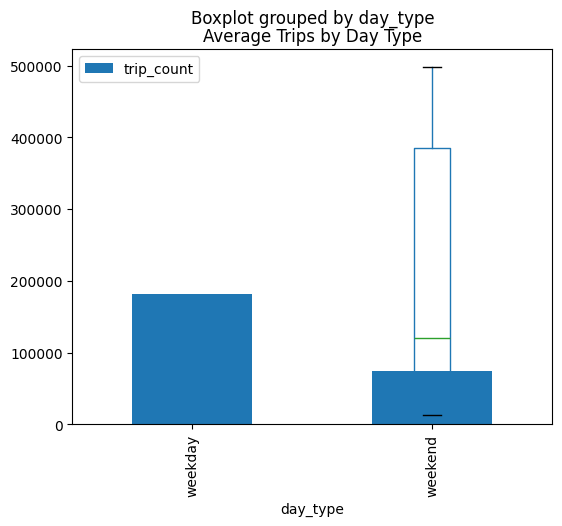

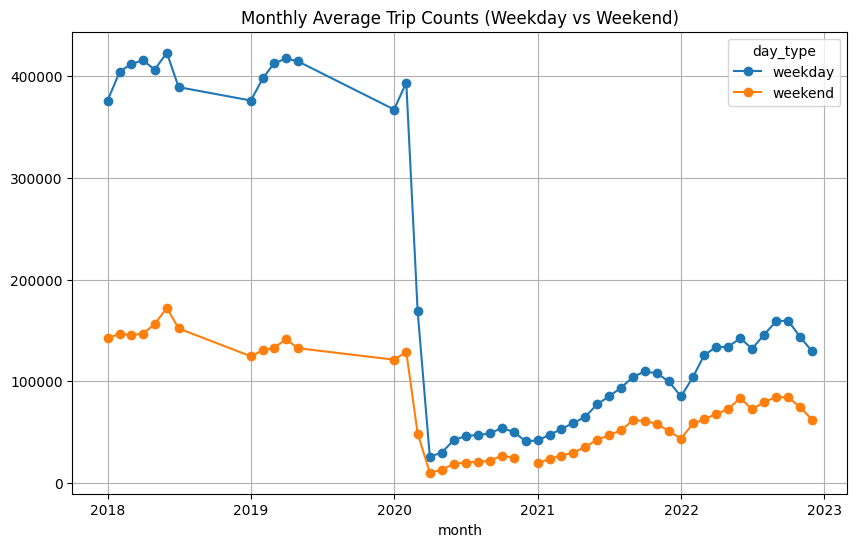

In [0]:
import pyspark.sql.functions as F

daily_counts_pd = daily_counts.toPandas()
monthly_counts_pd = monthly_counts.withColumn(
    "month", F.to_date(F.col("month"), "yyyy-MM-dd")
).toPandas()

# Boxplot
daily_counts_pd.boxplot(column="trip_count", by="day_type", figsize=(6,5))

# Bar chart (ค่าเฉลี่ย)
daily_counts_pd.groupby("day_type")["trip_count"].mean().plot(
    kind="bar", figsize=(6,5), legend=True, title="Average Trips by Day Type"
)

# Line chart (monthly trend)
monthly_counts_pd.pivot_table(index="month", columns="day_type", values="trip_count") \
    .plot(marker="o", figsize=(10,6), grid=True, title="Monthly Average Trip Counts (Weekday vs Weekend)")


In [0]:
import pyspark.pandas as ps
import plotly.express as px

daily_counts_ps = daily_counts.pandas_api()

fig = px.box(
    daily_counts_ps.to_pandas(),  
    x="day_type",
    y="trip_count",
    color="day_type",
    title="Distribution of Trip Counts: Weekday vs Weekend"
)
fig.show()

Tried to attach usage logger `pyspark.databricks.pandas.usage_logger`, but an exception was raised: JVM wasn't initialised. Did you call it on executor side?
/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1035: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1035: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [0]:
daily_avg = daily_counts_ps.groupby("day_type")["trip_count"].mean().reset_index()
fig = px.bar(daily_avg, x="day_type", y="trip_count", color="day_type",
             title="Average Trip Counts (Weekday vs Weekend)")
fig.show()

# Line chart monthly trend
monthly_counts_ps = monthly_counts.withColumn("month", F.to_date(F.col("month"), "yyyy-MM-01"))
monthly_counts_ps_spark = monthly_counts_ps.pandas_api()

fig = px.line(
    monthly_counts_ps_spark.to_pandas(),
    x="month",
    y="trip_count",
    color="day_type",
    markers=True,
    title="Monthly Average Trip Counts (Weekday vs Weekend)"
)
fig.show()

/databricks/python/lib/python3.12/site-packages/pyspark/pandas/groupby.py:653: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.

/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1035: PandasAPIOnSparkAdviceWarning:

The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.

/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1035: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1035: PandasAPIOnSparkAdviceWarning:

The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.

/databricks/python/lib/python3.12/site-packages/pyspark/pandas/utils.py:1035: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

data = data.withColumn(
    "Time Period", 
    F.when((F.col("hour") >= 5) & (F.col("hour") <= 11), "Morning")
    .when((F.col("hour") >= 12) & (F.col("hour") <= 15), "Afternoon")
    .when((F.col("hour") >= 16) & (F.col("hour") <= 19), "Evening")
    .when((F.col("hour") >= 20) & (F.col("hour") <= 24), "Night")
    .otherwise("Late Night") 
)


time_counts = data.groupBy("date", "Time Period").agg(F.sum("trip_count").alias("Total Trip Count"))  #.alias ตั้งชื่อใหม้่   .agg คำนวณสรุปข้อมูลโดย รวมค่าทั้งหมดของ ปี-เดือน-วัน นั้นๆ

# ใช้ Window เพื่อหาค่า Time Period ที่ Trip Count สูงสุดในแต่ละวัน
windowSpec = Window.partitionBy("date").orderBy(F.col("Total Trip Count").desc())


max_time_per_day = time_counts.withColumn("Rank", F.row_number().over(windowSpec)) \
                              .filter(F.col("Rank") == 1) \
                              .drop("Rank")


max_time_per_day.show()


+----------+-----------+----------------+
|      date|Time Period|Total Trip Count|
+----------+-----------+----------------+
|2018-01-01| Late Night|         27694.0|
|2018-01-02|    Morning|        138329.0|
|2018-01-03|    Morning|        153520.0|
|2018-01-04|    Morning|        153455.0|
|2018-01-05|    Morning|        140504.0|
|2018-01-06|    Evening|         43744.0|
|2018-01-07|  Afternoon|         31027.0|
|2018-01-08|    Morning|        161268.0|
|2018-01-09|    Morning|        169263.0|
|2018-01-10|    Morning|        171175.0|
|2018-01-11|    Morning|        172067.0|
|2018-01-12|    Morning|        154490.0|
|2018-01-13|    Evening|         46068.0|
|2018-01-14|    Evening|         33625.0|
|2018-01-15|    Morning|         61383.0|
|2018-01-16|    Morning|        177368.0|
|2018-01-17|    Morning|        176019.0|
|2018-01-18|    Morning|        174582.0|
|2018-01-19|    Morning|        160034.0|
|2018-01-20|  Afternoon|         81581.0|
+----------+-----------+----------

In [0]:
# คำนวณผลรวมของ Trip Count ตาม Time Period
time_counts_summary = data.groupBy("Time Period").agg(F.sum("trip_count").alias("sum"))


time_counts_summary_sorted = time_counts_summary.orderBy(F.col("sum").desc())


time_counts_summary_sorted.show()

+-----------+-----------+
|Time Period|        sum|
+-----------+-----------+
|    Morning|8.2720773E7|
|    Evening|7.3767371E7|
|  Afternoon|3.7960867E7|
|      Night|1.8894612E7|
| Late Night|  1843574.0|
+-----------+-----------+



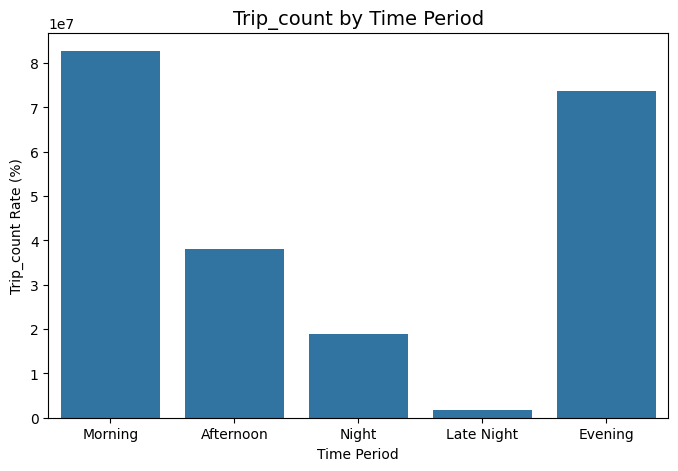

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# คำนวณผลรวมของ Trip Count ตาม Time Period
time_sum = data.groupBy("Time Period").agg(F.sum("trip_count").alias("trip_count"))

# แปลง DataFrame ของ PySpark เป็น pandas DataFrame
time_sum_pd = time_sum.toPandas()

# สร้างกราฟ
plt.figure(figsize=(8,5))
sns.barplot(x="Time Period", y="trip_count", data=time_sum_pd)
plt.title("Trip_count by Time Period", fontsize=14)
plt.xlabel("Time Period")
plt.ylabel("Trip_count Rate (%)")
plt.show()

#ข้อมูลมันไม่มี passenger และพยายามให้เป็นหัวข้ออัตราการใช้

+-----------+-----+
|Time Period|count|
+-----------+-----+
| Late Night|    1|
|    Morning|  987|
|    Evening|  199|
|  Afternoon|  234|
+-----------+-----+



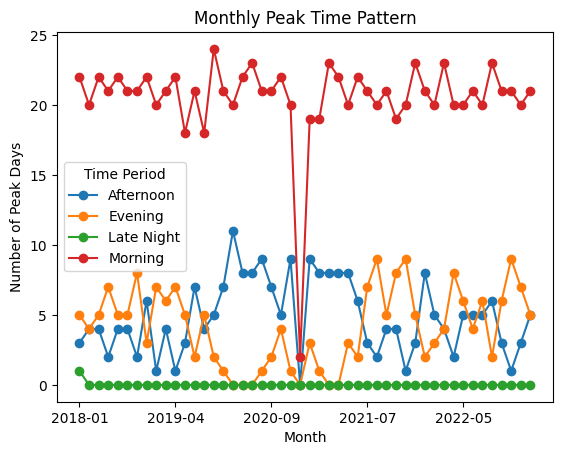

In [0]:
peak_counts = max_time_per_day.groupBy("Time Period").count()
peak_counts.show()

max_time_per_day = max_time_per_day.withColumn("month", F.date_format("date", "yyyy-MM"))

monthly_peak = max_time_per_day.groupBy("month", "Time Period").count().orderBy("month")

pdf2 = monthly_peak.toPandas()

# pivot เพื่อวาด line chart
pdf2 = pdf2.pivot(index="month", columns="Time Period", values="count").fillna(0)

pdf2.plot(kind="line", marker="o")
plt.title("Monthly Peak Time Pattern")
plt.xlabel("Month")
plt.ylabel("Number of Peak Days")
plt.show()

+-----------+-----+
|Time Period|count|
+-----------+-----+
| Late Night|    1|
|    Morning|  987|
|    Evening|  199|
|  Afternoon|  234|
+-----------+-----+



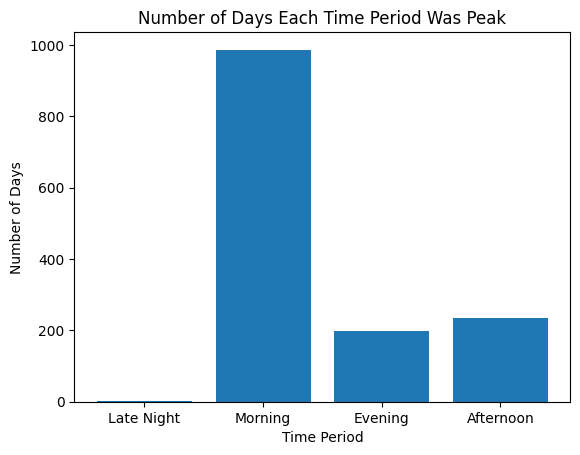

In [0]:
import matplotlib.pyplot as plt

peak_counts = max_time_per_day.groupBy("Time Period").count()
peak_counts.show()


pdf = peak_counts.toPandas()

plt.bar(pdf["Time Period"], pdf["count"])
plt.title("Number of Days Each Time Period Was Peak")
plt.xlabel("Time Period")
plt.ylabel("Number of Days")
plt.show()

In [0]:
from pyspark.sql.functions import year, sum as spark_sum

In [0]:

data_with_year = data.withColumn("year", year(data["date"]))

In [0]:

yearly_passengers = (
    data_with_year
    .groupBy("year")
    .agg(spark_sum("trip_count").alias("total_passengers"))
    .orderBy("year")
)

yearly_passengers.show()

+----+----------------+
|year|total_passengers|
+----+----------------+
|2018|     7.0419436E7|
|2019|      4.747731E7|
|2020|     3.0339302E7|
|2021|     2.4964402E7|
|2022|     4.1986747E7|
+----+----------------+



In [0]:

yearly_dict = {row["year"]: row["total_passengers"] for row in yearly_passengers.collect()}

In [0]:
# ฟังก์ชันคำนวณ Drop%
def drop_percent(base, compare):
    return ((yearly_dict[base] - yearly_dict[compare]) / yearly_dict[base]) * 100

In [0]:
# คำนวณเปรียบเทียบทุกคู่
results = []
years = sorted(yearly_dict.keys())

for i, base_year in enumerate(years):
    for compare_year in years[i+1:]:
        results.append({
            "Base Year": base_year,
            "Compare Year": compare_year,
            "Drop%": round(drop_percent(base_year, compare_year), 2)
        })

In [0]:

drop_df = spark.createDataFrame(results)
drop_df.show(truncate=False)
print(f"Drop% > 0 → จำนวนเที่ยวรถไฟ (เช่น Drop% = 40% → ลดลง 40% จากปีฐาน \nDrop% < 0 → จำนวนเที่ยวรถไฟ (เช่น Drop% = -2.10% → เพิ่มขึ้น 2.1% จากปีฐาน) \nDrop% = 0 → จำนวนเที่ยวรถไฟเท่ากับปีฐาน")

+---------+------------+------+
|Base Year|Compare Year|Drop% |
+---------+------------+------+
|2018     |2019        |32.58 |
|2018     |2020        |56.92 |
|2018     |2021        |64.55 |
|2018     |2022        |40.38 |
|2019     |2020        |36.1  |
|2019     |2021        |47.42 |
|2019     |2022        |11.56 |
|2020     |2021        |17.72 |
|2020     |2022        |-38.39|
|2021     |2022        |-68.19|
+---------+------------+------+

Drop% > 0 → จำนวนเที่ยวรถไฟ (เช่น Drop% = 40% → ลดลง 40% จากปีฐาน 
Drop% < 0 → จำนวนเที่ยวรถไฟ (เช่น Drop% = -2.10% → เพิ่มขึ้น 2.1% จากปีฐาน) 
Drop% = 0 → จำนวนเที่ยวรถไฟเท่ากับปีฐาน


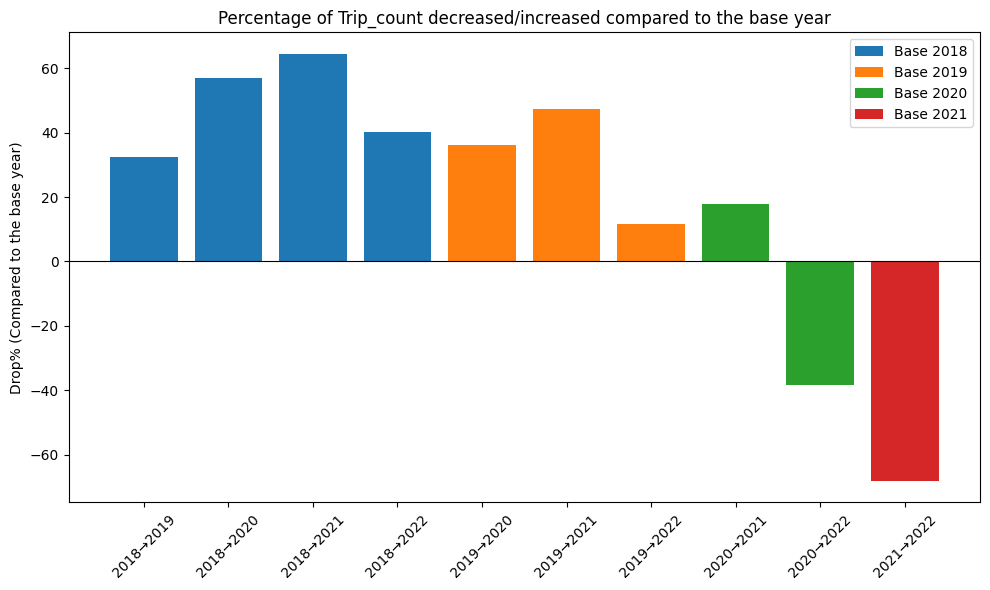

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# ผลลัพธ์ drop%
drop_results = []
for i, base_year in enumerate(years):
    for compare_year in years[i+1:]:
        drop_val = drop_percent(base_year, compare_year)
        drop_results.append([base_year, compare_year, drop_val])

drop_df = pd.DataFrame(drop_results, columns=["Base Year", "Compare Year", "Drop%"])

# ===== Plot Bar Chart =====
plt.figure(figsize=(10,6))

for base_year in drop_df["Base Year"].unique():
    subset = drop_df[drop_df["Base Year"] == base_year]
    plt.bar(
        [f"{base_year}→{y}" for y in subset["Compare Year"]],
        subset["Drop%"],
        label=f"Base {base_year}"
    )

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Drop% (Compared to the base year)")
plt.title("Percentage of Trip_count decreased/increased compared to the base year")
 # ติด - คือเพิ่มขึ้น
 # ติด + คือลดลง
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


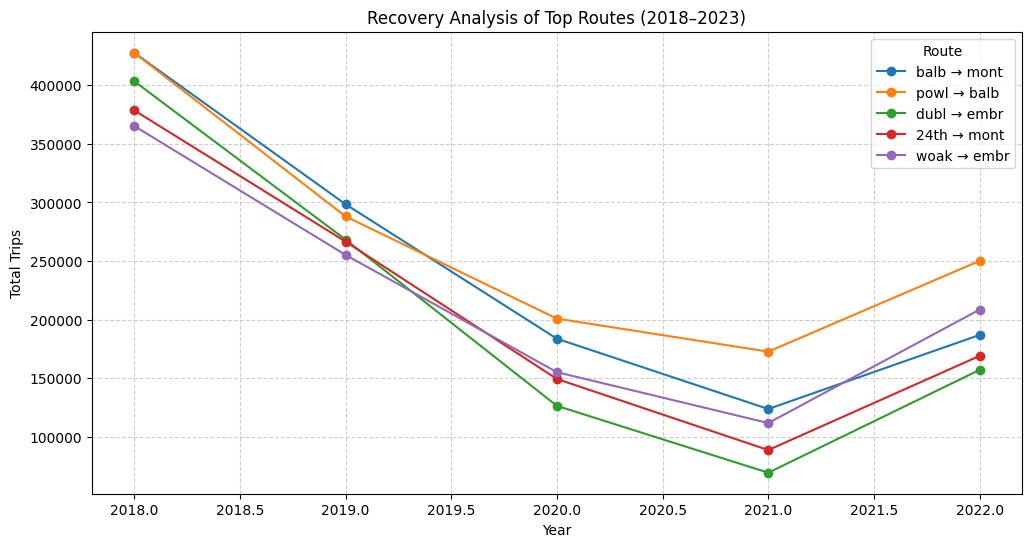

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

data = data.withColumn("year", F.year("date"))


yearly_trips = data.groupBy("year", "origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("total_trips"))

# สร้าง route column
yearly_trips = yearly_trips.withColumn(
    "route", 
    F.concat_ws(" → ", "origin_station", "destination_station")
)

pdf = yearly_trips.toPandas()

# เลือก top 5 routes ที่มีผู้โดยสารเยอะในปี 2019 (ก่อนโควิด)
top_routes = (
    pdf[pdf["year"] == 2019]
    .groupby("route")["total_trips"].sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# filter เฉพาะ top routes
pdf_top = pdf[pdf["route"].isin(top_routes)]

# วาดกราฟ line chart
plt.figure(figsize=(12,6))
for route in top_routes:
    route_data = pdf_top[pdf_top["route"] == route]
    plt.plot(route_data["year"], route_data["total_trips"], marker="o", label=route)

plt.title("Recovery Analysis of Top Routes (2018–2023)")
plt.xlabel("Year")
plt.ylabel("Total Trips")
plt.legend(title="Route")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


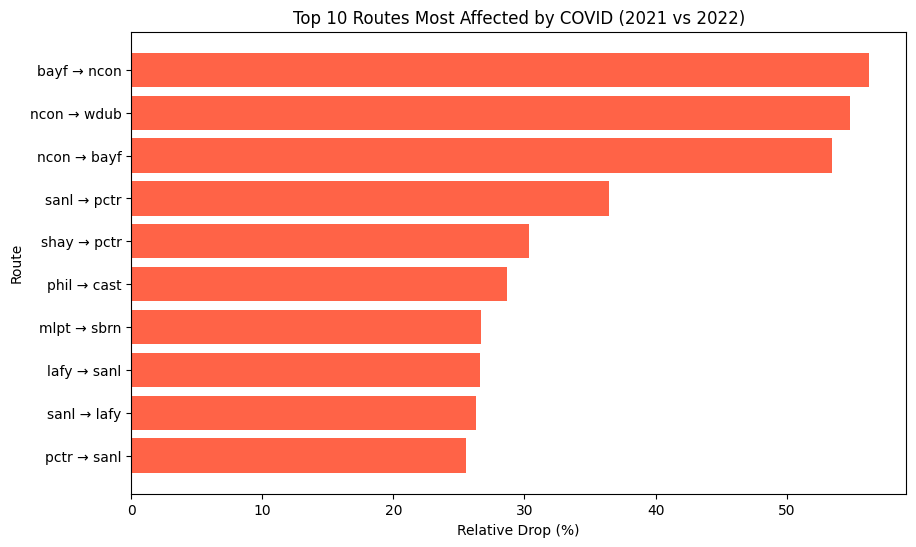

In [0]:
# รวมจำนวนผู้โดยสารต่อเส้นทางในปี 2021 และ 2022
#เลือก Top 10 Routes ที่ได้รับผลกระทบมากที่สุด
route_2021 = data.filter(F.col("year") == 2021) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2021"))

route_2022 = data.filter(F.col("year") == 2022) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2022"))

# รวมตาราง
route_compare = route_2021.join(
    route_2022,
    ["origin_station", "destination_station"],
    "inner"
)

# คำนวณผลกระทบ
route_compare = route_compare.withColumn(
    "absolute_drop", F.col("trips_2021") - F.col("trips_2022")
).withColumn(
    "relative_drop", ((F.col("trips_2021") - F.col("trips_2022")) / F.col("trips_2021")) * 100
).withColumn(
    "route", F.concat_ws(" → ", "origin_station", "destination_station")
)

# ดึง top 10 ตาม relative drop
top10_routes = route_compare.orderBy(F.col("relative_drop").desc()).limit(10).toPandas()

# วาดกราฟแท่ง
plt.figure(figsize=(10,6))
plt.barh(top10_routes["route"], top10_routes["relative_drop"], color="tomato")
plt.xlabel("Relative Drop (%)")
plt.ylabel("Route")
plt.title("Top 10 Routes Most Affected by COVID (2021 vs 2022)")
plt.gca().invert_yaxis()
plt.show()

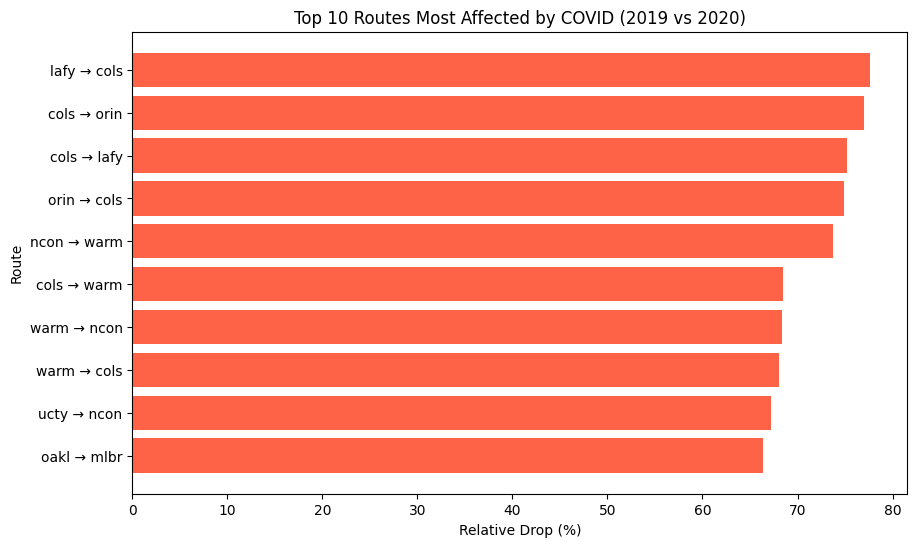

In [0]:
# รวมจำนวนผู้โดยสารต่อเส้นทางในปี 2019 และ 2020
#เลือก Top 10 Routes ที่ได้รับผลกระทบมากที่สุด
route_2019 = data.filter(F.col("year") == 2019) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2019"))

route_2020 = data.filter(F.col("year") == 2020) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2020"))

# รวมตาราง
route_compare = route_2019.join(
    route_2020,
    ["origin_station", "destination_station"],
    "inner"
)

# คำนวณผลกระทบ
route_compare = route_compare.withColumn(
    "absolute_drop", F.col("trips_2019") - F.col("trips_2020")
).withColumn(
    "relative_drop", ((F.col("trips_2019") - F.col("trips_2020")) / F.col("trips_2019")) * 100
).withColumn(
    "route", F.concat_ws(" → ", "origin_station", "destination_station")
)

# ดึง top 10 ตาม relative drop
top10_routes = route_compare.orderBy(F.col("relative_drop").desc()).limit(10).toPandas()

# วาดกราฟแท่ง
plt.figure(figsize=(10,6))
plt.barh(top10_routes["route"], top10_routes["relative_drop"], color="tomato")
plt.xlabel("Relative Drop (%)")
plt.ylabel("Route")
plt.title("Top 10 Routes Most Affected by COVID (2019 vs 2020)")
plt.gca().invert_yaxis()
plt.show()


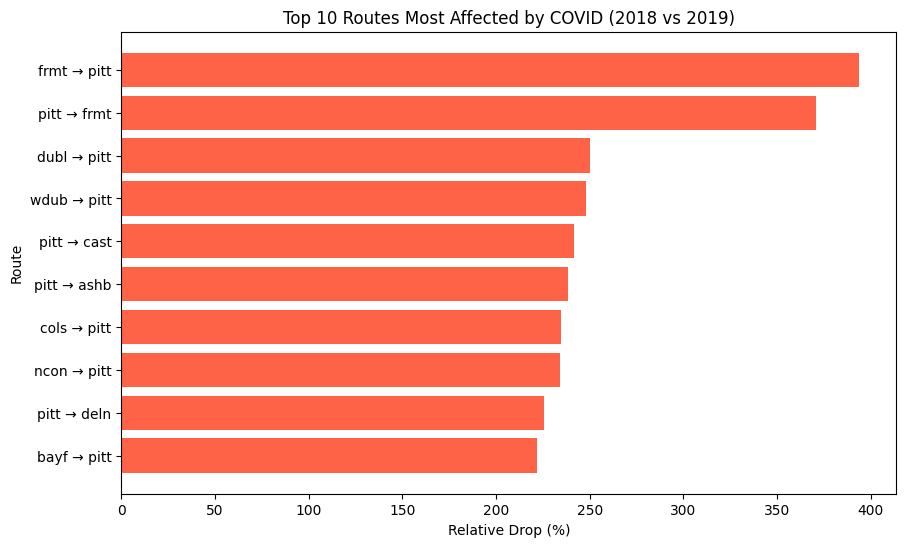

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# รวมจำนวนผู้โดยสารต่อเส้นทางในปี 2018 และ 2019
# เลือก Top 10 Routes ที่ได้รับผลกระทบมากที่สุด
route_2018 = data.filter(F.col("year") == 2018) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2018"))

route_2019 = data.filter(F.col("year") == 2019) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2019"))

# รวมตาราง
route_compare = route_2018.join(
    route_2019,
    ["origin_station", "destination_station"],
    "inner"
)

# คำนวณผลกระทบ
route_compare = route_compare.withColumn(
    "absolute_drop", F.col("trips_2018") - F.col("trips_2019")
).withColumn(
    "relative_drop", ((F.col("trips_2018") - F.col("trips_2019")) / F.col("trips_2019")) * 100
).withColumn(
    "route", F.concat_ws(" → ", "origin_station", "destination_station")
)

# ดึง top 10 ตาม relative drop
top10_routes = route_compare.orderBy(F.col("relative_drop").desc()).limit(10).toPandas()

# วาดกราฟแท่ง
plt.figure(figsize=(10,6))
plt.barh(top10_routes["route"], top10_routes["relative_drop"], color="tomato")
plt.xlabel("Relative Drop (%)")
plt.ylabel("Route")
plt.title("Top 10 Routes Most Affected by COVID (2018 vs 2019)")
plt.gca().invert_yaxis()
plt.show()

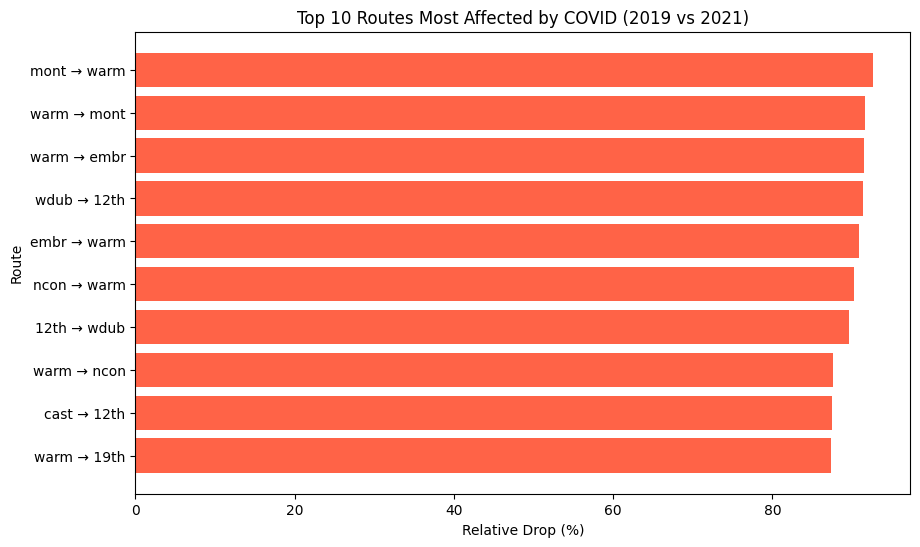

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# รวมจำนวนผู้โดยสารต่อเส้นทางในปี 2019 และ 2021
# เลือก Top 10 Routes ที่ได้รับผลกระทบมากที่สุด
route_2019 = data.filter(F.col("year") == 2019) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2019"))

route_2021 = data.filter(F.col("year") == 2021) \
    .groupBy("origin_station", "destination_station") \
    .agg(F.sum("trip_count").alias("trips_2021"))

# รวมตาราง
route_compare = route_2019.join(
    route_2021,
    ["origin_station", "destination_station"],
    "inner"
)

# คำนวณผลกระทบ
route_compare = route_compare.withColumn(
    "absolute_drop", F.col("trips_2019") - F.col("trips_2021")
).withColumn(
    "relative_drop", ((F.col("trips_2019") - F.col("trips_2021")) / F.col("trips_2019")) * 100
).withColumn(
    "route", F.concat_ws(" → ", "origin_station", "destination_station")
)

# ดึง top 10 ตาม relative drop
top10_routes = route_compare.orderBy(F.col("relative_drop").desc()).limit(10).toPandas()

# วาดกราฟแท่ง
plt.figure(figsize=(10,6))
plt.barh(top10_routes["route"], top10_routes["relative_drop"], color="tomato")
plt.xlabel("Relative Drop (%)")
plt.ylabel("Route")
plt.title("Top 10 Routes Most Affected by COVID (2019 vs 2021)")
plt.gca().invert_yaxis()
plt.show()


In [0]:
from pyspark.sql.functions import year, sum as spark_sum, col, concat_ws

# รวม origin และ destination เป็น route
routes = data.withColumn("route", concat_ws(" → ", col("origin_station"), col("destination_station")))

# รวม trip_count ตาม route และปี
route_yearly = (
    routes.withColumn("year", year(col("date")))
          .groupBy("route", "year")
          .agg(spark_sum("trip_count").alias("total_trips"))
)

# เก็บปีฐาน (2019)
base_year = 2019
base_data = route_yearly.filter(col("year") == base_year).withColumnRenamed("total_trips", "base_trips")

# join กับปีอื่น ๆ
compare_data = route_yearly.filter(col("year") > base_year)

joined = (
    compare_data.join(base_data.select("route", "base_trips"), on="route", how="inner")
                .withColumn("Drop%", ((col("base_trips") - col("total_trips")) / col("base_trips")) * 100)
)

# หาเส้นทางที่ Drop หนักที่สุด
worst_routes = joined.orderBy(col("Drop%").desc())
worst_routes.show(10, truncate=False)


+-----------+----+-----------+----------+-----------------+
|route      |year|total_trips|base_trips|Drop%            |
+-----------+----+-----------+----------+-----------------+
|mont → warm|2021|6126.0     |83710.0   |92.6818779118385 |
|warm → mont|2021|7365.0     |88505.0   |91.67843624653975|
|warm → embr|2021|7742.0     |91532.0   |91.54175588865097|
|wdub → 12th|2021|1294.0     |15018.0   |91.38367292582234|
|embr → warm|2021|7261.0     |79668.0   |90.88592659537079|
|ncon → warm|2021|100.0      |1022.0    |90.21526418786692|
|12th → wdub|2021|1544.0     |14867.0   |89.6145826326764 |
|warm → ncon|2021|102.0      |827.0     |87.66626360338573|
|cast → 12th|2021|1700.0     |13573.0   |87.47513445811538|
|warm → 19th|2021|2881.0     |22766.0   |87.34516384081526|
+-----------+----+-----------+----------+-----------------+
only showing top 10 rows


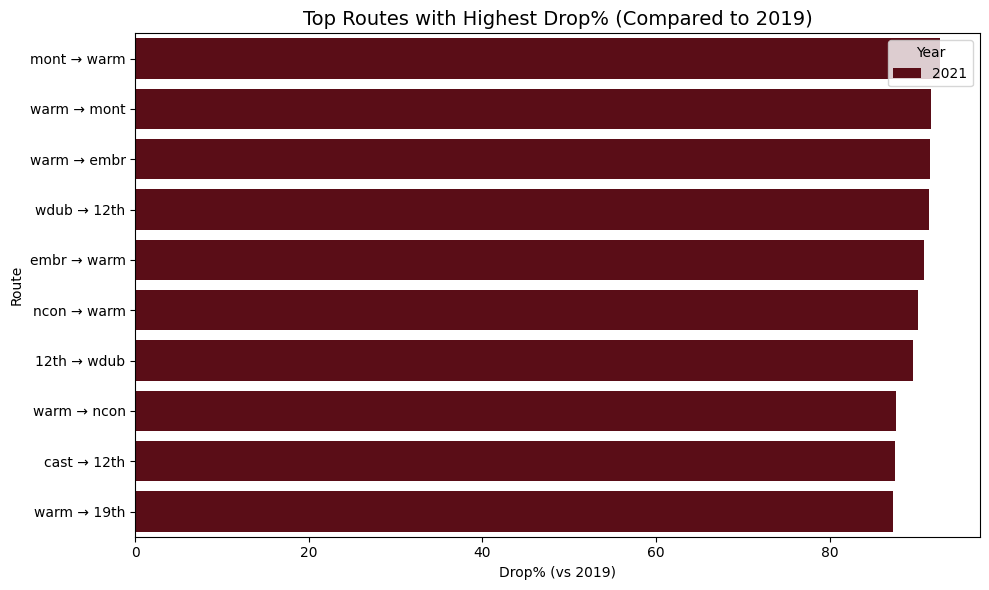

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# แปลงเป็น Pandas DataFrame
worst_routes_pd = worst_routes.limit(10).toPandas()  # เลือก Top 10

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x="Drop%",
    y="route",
    hue="year",
    data=worst_routes_pd,
    palette="Reds_r"
)
plt.title("Top Routes with Highest Drop% (Compared to 2019)", fontsize=14)
plt.xlabel("Drop% (vs 2019)")
plt.ylabel("Route")
plt.legend(title="Year")
plt.tight_layout()
plt.show()